# コメントをやる

やること：帰無仮説が正しいのに棄却してしまう確立が5パーセントかを調べる

なのでまずは純粋戦略ナッシュ均衡のデータを作る

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import inv
from numpy.random import *
import numdifftools as nd
from sklearn import linear_model

サンプルでーた

In [6]:
# データ作る
s = st.norm()
e = st.norm()
M = 1000
T = 100
beta1 = 0.8
beta2 = -0.5
beta3 = -0.5
delta = -0.25
cut = 0.5
tole = 0.000005
maxx = 100000
rs1 = 1
rs2 = 2
# Pure strategyデータの作成

def nash2(x, true_mu, true_delta):
    if x[0] < -true_mu:
        if x[1] < -true_mu:
            return [0,0,0]
        else :
            return [0,1,1]
    elif -true_mu < x[0] < -true_mu -true_delta:
        if x[1] < -true_mu:
            return [1,0,2]
        elif -true_mu < x[1] < -true_mu -true_delta:
            return [1,0,2]
        else:
            return [0,1,1]
    else:
        if x[1] < -true_mu -true_delta:
            return [1,0,2]
        else:
            return [1,1,3]

def diff(p):
    p_0 = sum([True for i in data2[p, :, 2] if i == 0.0])/T
    p_2 = sum([True for i in data2[p, :, 2] if i == 3.0])/T
    return p_0 - p_2

def num(p):
    num0 = sum([True for i in data2[p, :, 2] if i == 0.0])
    num2 = sum([True for i in data2[p, :, 2] if i == 3.0])
    num1 = T - num0 - num2
    return num0, num1, num2

data = e.rvs(size = (M,3), random_state = rs1)
eps = s.rvs(size = (M,T,2), random_state = rs2)
data2 = np.ones((M,T,3))
for m in range(M):
    for t in range(T):
        data2[m, t, :] = nash2(eps[m, t, :], data[m, 0]*beta1 + data[m, 1]*beta2, delta)

d = np.array([diff(p) for p in range(M)])
d2 = np.reshape(np.array([num(p) for p in range(M)]), (M, 3))
df = pd.DataFrame({"Pop" : data[:,0], "Dist1" : data[:, 1], "Dist2" : data[:, 2], "diff" : d, "num0":d2[:, 0], "num1":d2[:, 1], "num2":d2[:, 2]})
#df = df[(beta1 * df.Pop + beta2 * df.Dist1 + delta > cut) & (beta1 * df.Pop + beta2 * df.Dist2 + delta > cut)]
pop = df[["Pop"]].values[:, 0]
dist1 = df[["Dist1"]].values[:, 0]
dist2 = df[["Dist2"]].values[:, 0]
num0 = df[["num0"]].values[:, 0]
num2 = df[["num2"]].values[:, 0]
diff = df[["diff"]].values[:, 0]

推定の道具

In [6]:
def br(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = num0*(np.log(s.cdf(-xb1)*s.cdf(-xb2))) \
    + num2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + (T-num0-num2)*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return sum(logl)

def br1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = num0*(np.log(s.cdf(-xb1)*s.cdf(-xb2))) \
    + num2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + (T-num0-num2)*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return logl

def robust(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = (diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2))**2
    return -sum(r)

def robust1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2)
    return r

def NR(initial, fun, tol, maxit):
    theta = initial
    for i in range(0,maxit):
        G = nd.Gradient(fun)(theta)
        H = nd.Hessian(fun)(theta)
        del_theta = inv(H).dot(G)
        theta = theta - del_theta
        if np.linalg.norm(del_theta) < tol:
            print("NR終わり")
            break
    return theta

In [5]:
initial = [0.8,-0.5,-0.25]
result_br = NR(initial, br, tole, maxx)
result_rob = NR(initial, robust, tole, maxx)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-pac

NR終わり
NR終わり


ハウスマン

In [7]:
def hausman(result1, result2):
    H_br = nd.Hessian(br)(result1)
    inv_H_br = inv(H_br)
    tri_1 = -inv_H_br

    J_br = nd.Jacobian(br1)(result1)
    circle_1 = np.dot(J_br.T, J_br)

    G_rob = nd.Gradient(robust)(result2)
    a = np.matrix(G_rob)
    tri_3 = -np.dot(inv(np.dot(a.T, a)), a.T)

    b = np.matrix(robust1(result2)).T
    circle_3 = np.dot(J_br.T, b)

    circle_6 = robust(result2)

    A_11 = np.dot(np.dot(tri_1, circle_1), tri_1.T)/M
    A_33 = np.dot(np.dot(tri_3, circle_6), tri_3.T)/M
    A_13 = np.dot(np.dot(tri_1, circle_3), tri_3.T)/M
    A_31 = np.dot(np.dot(tri_3, circle_3.T), tri_1.T)/M
    
    avar = A_11 - A_13 -A_31 + A_33
    gap = np.matrix(result1 - result2)
    h = M * np.dot(np.dot(gap, inv(avar)), gap.T)
    
    return h, np.rank(avar)

In [7]:
h, rank = hausman(result_br, result_rob)
print(h)
print(rank)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-pac

[[ 95864336.25938895]]
2


/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [12]:
np.ones(2)

array([ 1.,  1.])

## 100回ハウスマン

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import inv
from numpy.random import *
import numdifftools as nd
from sklearn import linear_model

initial = [0.8,-0.5,-0.25]
s = st.norm()
e = st.norm()
times = 100
M = 1000
T = 100
beta1 = 0.8
beta2 = -0.5
beta3 = -0.5
delta = -0.25
cut = 0.5
tole = 0.000005
maxx = 100000
hausman_result = np.ones(times)

def nash2(x, true_mu, true_delta):
    if x[0] < -true_mu:
        if x[1] < -true_mu:
            return [0,0,0]
        else :
            return [0,1,1]
    elif -true_mu < x[0] < -true_mu -true_delta:
        if x[1] < -true_mu:
            return [1,0,2]
        elif -true_mu < x[1] < -true_mu -true_delta:
            return [1,0,2]
        else:
            return [0,1,1]
    else:
        if x[1] < -true_mu -true_delta:
            return [1,0,2]
        else:
            return [1,1,3]

def diffe(p, d):
    p_0 = sum([True for i in d[p, :, 2] if i == 0.0])/T
    p_2 = sum([True for i in d[p, :, 2] if i == 3.0])/T
    return p_0 - p_2

def num(p, d):
    num0 = sum([True for i in d[p, :, 2] if i == 0.0])
    num2 = sum([True for i in d[p, :, 2] if i == 3.0])
    num1 = T - num0 - num2
    return num0, num1, num2

def br(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = num0*(np.log(s.cdf(-xb1)*s.cdf(-xb2))) \
    + num2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + (T-num0-num2)*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return sum(logl)

def br1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    logl = num0*(np.log(s.cdf(-xb1)*s.cdf(-xb2))) \
    + num2*(np.log(s.cdf(xb1+x[2])*s.cdf(xb2+x[2])))\
    + (T-num0-num2)*np.log(1-s.cdf(-xb1)*s.cdf(-xb2)-s.cdf(xb1+x[2])*s.cdf(xb2+x[2]))
    return logl

def robust(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = (diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2))**2
    return -sum(r)

def robust1(x):
    xb1 = x[0] * pop + x[1] * dist1
    xb2 = x[0] * pop + x[1] * dist2
    r = diff + s.cdf(xb1 + x[2])*s.cdf(xb2 + x[2]) - s.cdf(-xb1)*s.cdf(-xb2)
    return r

def NR(initial, fun, tol, maxit):
    theta = initial
    for i in range(0,maxit):
        G = nd.Gradient(fun)(theta)
        H = nd.Hessian(fun)(theta)
        del_theta = inv(H).dot(G)
        theta = theta - del_theta
        if np.linalg.norm(del_theta) < tol:
            print("NR終わり")
            break
    return theta

def hausman(result1, result2):
    H_br = nd.Hessian(br)(result1)
    inv_H_br = inv(H_br)
    tri_1 = -inv_H_br

    J_br = nd.Jacobian(br1)(result1)
    circle_1 = np.dot(J_br.T, J_br)

    G_rob = nd.Gradient(robust)(result2)
    a = np.matrix(G_rob)
    tri_3 = -np.dot(inv(np.dot(a.T, a)), a.T)

    b = np.matrix(robust1(result2)).T
    circle_3 = np.dot(J_br.T, b)

    circle_6 = robust(result2)

    # ここら辺のMの処理を確認
    A_11 = np.dot(np.dot(tri_1, circle_1), tri_1.T)/M
    A_33 = np.dot(np.dot(tri_3, circle_6), tri_3.T)/M
    A_13 = np.dot(np.dot(tri_1, circle_3), tri_3.T)/M
    A_31 = np.dot(np.dot(tri_3, circle_3.T), tri_1.T)/M
    
    avar = A_11 - A_13 -A_31 + A_33
    gap = np.matrix(result1 - result2)
    h = M * np.dot(np.dot(gap, inv(avar)), gap.T)
    
    return h, np.rank(avar)

In [2]:
for time in range(times):
    data = e.rvs(size = (M,3), random_state = time)
    eps = s.rvs(size = (M,T,2), random_state = time+100)
    data2 = np.ones((M,T,3))
    for m in range(M):
        for t in range(T):
            data2[m, t, :] = nash2(eps[m, t, :], data[m, 0]*beta1 + data[m, 1]*beta2, delta)
    d = np.array([diffe(p, data2) for p in range(M)])
    d2 = np.reshape(np.array([num(p, data2) for p in range(M)]), (M, 3))
    df = pd.DataFrame({"Pop" : data[:,0], "Dist1" : data[:, 1], "Dist2" : data[:, 2], "diff" : d, "num0":d2[:, 0], "num1":d2[:, 1], "num2":d2[:, 2]})
    #df = df[(beta1 * df.Pop + beta2 * df.Dist1 + delta > cut) & (beta1 * df.Pop + beta2 * df.Dist2 + delta > cut)]
    pop = df[["Pop"]].values[:, 0]
    dist1 = df[["Dist1"]].values[:, 0]
    dist2 = df[["Dist2"]].values[:, 0]
    num0 = df[["num0"]].values[:, 0]
    num2 = df[["num2"]].values[:, 0]
    diff = df[["diff"]].values[:, 0]
    
    result_br = NR(initial, br, tole, maxx)
    result_rob = NR(initial, robust, tole, maxx)
    
    h, rank = hausman(result_br, result_rob)
    
    hausman_result[time] = h[0, 0]

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/core.py:951: RuntimeWarning: invalid value encountered in double_scalars
  f(x - ee[i, :] + ee[j, :], *args, **kwargs) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/core.py:951: RuntimeWarning: invalid value encountered in double_scalars
  f(x - ee[i, :] + ee[j, :], *args, **kwargs) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: i

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/core.py:951: RuntimeWarning: invalid value encountered in double_scalars
  f(x - ee[i, :] + ee[j, :], *args, **kwargs) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: i

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))
/Users/susu/anaconda/lib/python3.5/site-p

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

NR終わり
NR終わり


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/susu/anaconda/lib/python3.5/site-packages/numdifftools/limits.py:152: RuntimeWa

(array([ 97.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([ -2.42435004e+00,   3.11588625e+08,   6.23177253e+08,
          9.34765880e+08,   1.24635451e+09,   1.55794314e+09,
          1.86953176e+09,   2.18112039e+09,   2.49270902e+09,
          2.80429765e+09,   3.11588627e+09]),
 <a list of 10 Patch objects>)

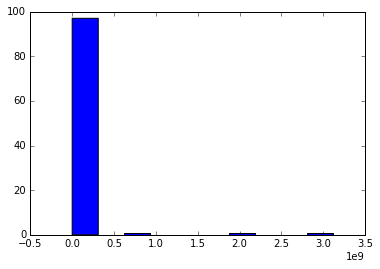

In [4]:
plt.hist(hausman_result)

In [5]:
hausman_result

array([ -2.45912121e-04,   1.59900341e+08,  -6.11594625e-02,
         6.71454466e+07,  -3.48563056e-01,   8.06219147e+07,
         6.21230260e+07,   1.65240854e+08,  -1.15723977e-01,
        -1.45702732e-04,   2.91186706e+07,   7.78322594e+07,
        -1.73106230e-02,   4.15127329e-03,   1.29707395e-06,
         8.61223583e-07,  -4.45181912e-06,   3.58312084e+07,
         1.06459572e+08,   7.35234121e+07,   8.74688308e+07,
         1.88879889e+09,   4.97207273e+07,   5.89964586e+07,
        -4.80806603e-03,   1.58290795e+08,   1.28947499e-04,
         1.17144810e+08,   1.01813426e-06,   8.79737232e+07,
         3.11588627e+09,   1.00933990e+08,   8.33001774e+07,
        -8.50239689e-03,  -8.91467437e-04,   3.55968839e+07,
         9.00292039e+07,   2.17059811e+07,   3.38701090e+07,
        -3.28268402e-04,   9.54983891e+07,   5.03328453e+07,
         5.40128504e+07,   1.36863327e-04,  -2.42435004e+00,
        -2.15252522e+00,   6.94233673e+07,   9.60592942e+07,
         5.23737483e+07,